In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, log_loss
import pandas as pd
import numpy as np
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
import time
from collections import deque
import AMM_SGDClassifier
import helpers

c:\Users\Diego\anaconda3\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\Diego\anaconda3\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_disc

# Load Data

In [2]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')


# Dummy Data Load

In [3]:
# np.random.seed(42)

# # Number of rows and columns
# num_rows = 1000
# num_columns = 41

# # Generate random float data for 39 columns
# float_data = np.random.rand(num_rows, num_columns - 2)

# # Generate two binary columns
# binary_data = np.random.randint(0, 2, size=(num_rows, 2))

# # Combine into a single dataset
# data = np.hstack((float_data, binary_data))

# # Create column names
# column_names = [f"feature_{i}" for i in range(1, num_columns - 1)]
# column_names.append("Gender")
# column_names.append("CHD")

# # Create DataFrame
# dummy_df= pd.DataFrame(data, columns=column_names)



In [4]:
# feature_columns = dummy_df.columns[:-1]  # All features except the last three columns
# sensitive_column = dummy_df.columns[-2]  # The third last column as the sensitive feature
# label_columns = dummy_df.columns[-1]  # The last two columns as labels

# # Convert Pandas DataFrame to a TensorFlow dataset with three components
# dataset = tf.data.Dataset.from_tensor_slices((
#     dummy_df[feature_columns].values,  # Features
#     dummy_df[sensitive_column].values.reshape(-1, 1),  # Sensitive feature (reshaped for batching)
#     dummy_df[label_columns].values  # Labels
# ))

# # Define batch size
# batch_size = 16  # You can adjust this as needed

# # Batch the dataset
# batched_dataset = dataset.batch(batch_size)

# Process Real Data

In [5]:
batched_dataset, X_val, y_val, X_test, y_test = helpers.data_processor(df, 32)

In [6]:
model = AMM_SGDClassifier.AdversarialModel(41, lambda_tradeoff=0.3)

In [7]:
model.fit(batched_dataset)


Epoch 1/100
860/860 [==============================] - 21s 25ms/step - loss: 0.0098 - accuracy: 0.9577

Epoch 2/100
860/860 [==============================] - 21s 24ms/step - loss: 1.5962 - accuracy: 0.9581

Epoch 3/100
860/860 [==============================] - 21s 24ms/step - loss: 1.5401 - accuracy: 0.9582

Epoch 4/100
860/860 [==============================] - 21s 24ms/step - loss: -0.1026 - accuracy: 0.9582

Epoch 5/100
860/860 [==============================] - 21s 24ms/step - loss: -0.0942 - accuracy: 0.9583

Epoch 6/100
860/860 [==============================] - 21s 24ms/step - loss: -0.1157 - accuracy: 0.9583

Epoch 7/100
860/860 [==============================] - 21s 25ms/step - loss: -0.0837 - accuracy: 0.9583

Epoch 8/100
860/860 [==============================] - 22s 26ms/step - loss: 0.1856 - accuracy: 0.9583

Epoch 9/100
860/860 [==============================] - 22s 25ms/step - loss: -0.1740 - accuracy: 0.9583

Epoch 10/100
860/860 [==============================] - 21

In [15]:
X_val_array = np.array(X_val).astype(np.float32) 
X_val_tensor = tf.convert_to_tensor(X_val_array, dtype=tf.float32)
raw_preds = model.predict(X_val_tensor, raw_probabilities=True)

287/287 [==============================] - 0s 685us/step


In [16]:
preds = (raw_preds >= 0.11).astype(int)
preds = preds.flatten()
y_val = y_val.astype(int)

In [17]:
helpers.model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.898407,0.456091,0.178889


In [18]:
fairness_df = X_val.copy()
fairness_df['Coronary heart disease'] = y_val

In [19]:
helpers.fairness_metrics(fairness_df, preds)

,Metric,Value
0,Demographic Parity Difference,0.099896
1,Equal Opportunity Difference,0.325022
2,Predictive Parity,0.099896
3,Disparate Impact,3.006848


In [20]:
thresholds = np.arange(0.01,1, 0.05)
f1_scores = []
for t in thresholds:
    preds = (raw_preds >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.11


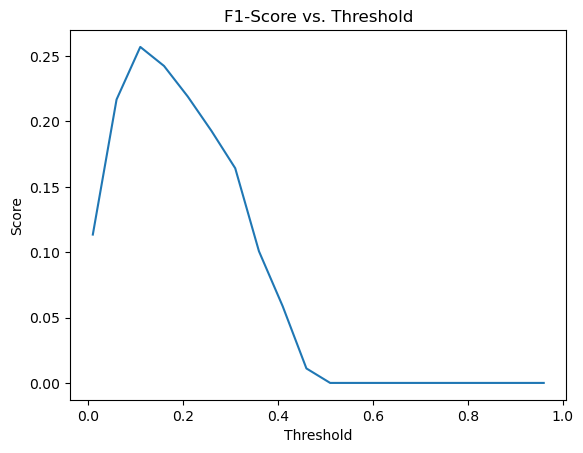

In [21]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()